In [1]:
from Planetary_fits import *



In [2]:
from Common_functions import smooth, localize_event, prepare
import glob,os,sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
import re
import scipy.stats as st
from os.path import expanduser
import cmath
import scipy.optimize as op
import time
import gzip
import matplotlib.patches as patches
import pandas as pd
import scipy.special as sp
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import (mark_inset,inset_axes,InsetPosition)
from sympy.solvers import solve
from sympy import Symbol
import sympy
from matplotlib.lines import Line2D  
import time
from lmfit import minimize, Parameters, Parameter, report_fit


%matplotlib inline

In [3]:
def deviation_finder (t, A_residual, PSPL_params,  binsize_initial = 600, threshold_default = 3):
    
    std_base = np.std(A_residual[(t > PSPL_params[0]+10*PSPL_params[1]) | (t < PSPL_params[0]-10*PSPL_params[1]) ])
    std_all = np.std(A_residual)
    percent_diff = (np.abs(std_base-std_all)/float(std_all))*100
    
    if percent_diff < 50:
        smoothie ='yes'
#         print 'Smooth'
    else:
        smoothie ='no'
#         print 'Do not smooth'
        
    b_s = binsize_initial
    
    n_out, peaks = count_peaks (t, A_residual, smooth=smoothie, bin_size =b_s, threshold = threshold_default)

    n_peaks = len(peaks)
    temp_peaks = peaks
#     print n_peaks
    
    c = 0
    
    if (c != 2) & (percent_diff > 5):
    
        while c != 2 :
            if b_s < 0.2:
#                 print 'No two peaks were found!'
                break

            b_s = b_s/2.
#             print b_s
            n_out2, temp_peaks = count_peaks (t, A_residual, smooth=smoothie, bin_size =b_s, threshold = 3)
            c = len(temp_peaks)
    
    if len(temp_peaks) == 2 :
        if np.abs(temp_peaks[0]-temp_peaks[1])<100:
            peaks = temp_peaks
            n_peaks = len(temp_peaks)
            
        
        if np.abs(temp_peaks[1]-temp_peaks[0]) <0.1:
            b_s_ = [4,3,2, 1, 0.5]
            for b in b_s_:
                
                n_out, temp_peaks = count_peaks (t, A_residual, smooth='yes', bin_size =b, threshold = 3)
 
                if (len(temp_peaks) == 2):
                    if (np.abs(temp_peaks[1]-temp_peaks[0]) >0.1):
                    
                        peaks = temp_peaks
                        n_peaks = len(temp_peaks)
                        print 'yes'
                    
                    
    return n_peaks, peaks


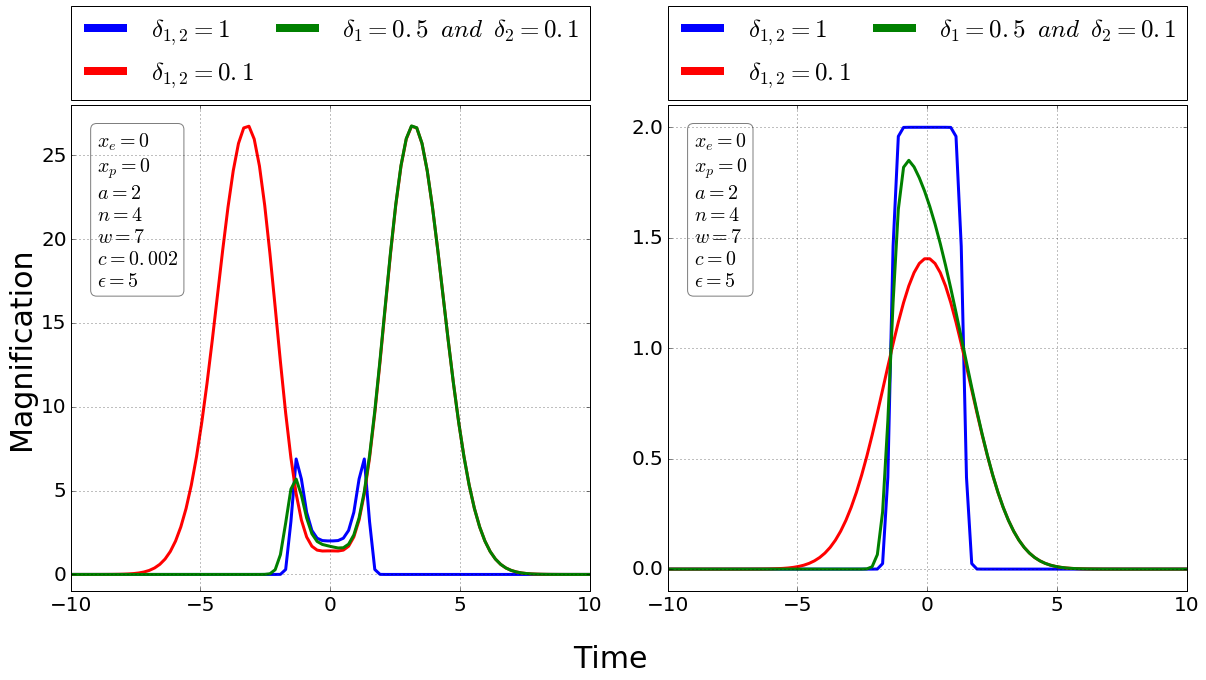

In [4]:
fig, axs = plt.subplots(1, 2)

legend_elements = []

x = np.linspace(-10,10,100)




xe_1 = 0
xp_1 = 0
b1_1 = 1
b2_1 = 1
a_1 = 2
n_1 = 4
w_1 = 7
c_1 = 0.002 
s_1 = 5 

textstr0 = '\n'.join((
    r'$x_e=%.0f$' % (xe_1, ),
    r'$x_p=%.0f$' % (xp_1, ),
    r'$a=%.0f$' % (a_1, ),
    r'$n=%.0f$' % (n_1, ),
    r'$w=%.0f$' % (w_1, ),
    r'$c=%.3f$' % (c_1, ),
    r'$\epsilon=%.0f$' % (s_1, )))

axs[0].plot(x, Double_horn(xe_1, xp_1, b1_1, b2_1, a_1, n_1, w_1, c_1, s_1, x),
            'b-', markersize=22, label = 'All lc', linewidth = 3)
legend_elements.append(Line2D([0], [0], lw=8, color = 'b' , label = '${\delta}_{1,2} = 1$'))
axs[0].plot(x, Double_horn(xe_1, xp_1, b1_1/10., b2_1/10., a_1, n_1, w_1, c_1, s_1, x),
            'r-', markersize=22, label = 'All lc', linewidth = 3)
legend_elements.append(Line2D([0], [0], lw=8, color = 'r' , label = '${\delta}_{1,2} = 0.1$'))
axs[0].plot(x, Double_horn(xe_1, xp_1, b1_1/2., b2_1/10., a_1, n_1, w_1, c_1, s_1, x),
            'g-', markersize=22, label = 'All lc', linewidth = 3)
legend_elements.append(Line2D([0], [0], lw=8, color = 'g' , label = '${\delta}_{1} = 0.5 \;\; and \;\; {\delta}_{2} = 0.1$'))

axs[0].grid()
axs[0].legend(bbox_to_anchor=(0., 1.01, 1., .08),handles=legend_elements, loc='lower left',
           ncol=2, mode="expand", borderaxespad=0. ,prop={'size': 25})
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='none', alpha=0.5)

# place a text box in upper left in axes coords
axs[0].text(0.05, 0.95, textstr0, transform=axs[0].transAxes, fontsize=20,
        verticalalignment='top', bbox=props)

# axs[0].set_xlabel('$tE_{trapezoid}$', size = 30)
axs[0].set_ylabel('Magnification', size = 30)

legend_elements = []

xe_2 = 0
xp_2 = 0
b1_2 = 1
b2_2 = 1
a_2 = 2
n_2 = 4
w_2 = 7
c_2 = 0 
s_2 = 5

textstr1 = '\n'.join((
    r'$x_e=%.0f$' % (xe_2, ),
    r'$x_p=%.0f$' % (xp_2, ),
    r'$a=%.0f$' % (a_2, ),
    r'$n=%.0f$' % (n_2, ),
    r'$w=%.0f$' % (w_2, ),
    r'$c=%.0f$' % (c_2, ),
    r'$\epsilon=%.0f$' % (s_2, )))

axs[1].plot(x, Double_horn(xe_2, xp_2, b1_2, b2_2, a_2, n_2, w_2, 0, s_2, x),'b-', label='All lc', linewidth = 3)
legend_elements.append(Line2D([0], [0], lw=8 , label = '${\delta}_{1,2} = 1$',color = 'b'))
axs[1].plot(x, Double_horn(xe_2, xp_2, b1_2/10., b2_2/10., a_2, n_2, w_2, 0, s_2, x),'r-',label='All lc', linewidth = 3)
legend_elements.append(Line2D([0], [0], lw=8, label = '${\delta}_{1,2} = 0.1$', color = 'r'))
axs[1].plot(x, Double_horn(xe_2, xp_2, b1_2/2., b2_2/10., a_2, n_2, w_2, 0, s_2, x),'g-',label='All lc', linewidth = 3)
legend_elements.append(Line2D([0], [0], lw=8, label = '${\delta}_{1} = 0.5 \;\; and \;\; {\delta}_{2} = 0.1$', color = 'g'))

axs[1].grid()
axs[1].legend(bbox_to_anchor=(0., 1.01, 1., .08),handles=legend_elements, loc='lower left',
           ncol=2, mode="expand", borderaxespad=0. ,prop={'size': 25})
axs[0].set_ylim(-1,28)


# axs[1].set_xlabel(r'$True \; value \; of \; \rho$', size = 30)
# axs[1].set_ylabel(r'$ Number $', size = 30)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=0.15, hspace=0.08) 
axs[1].set_ylim(-0.1,2.1)
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='none', alpha=0.5)

# place a text box in upper left in axes coords
axs[1].text(0.05, 0.95, textstr1, transform=axs[1].transAxes, fontsize=20,
        verticalalignment='top', bbox=props)

plt.subplots_adjust(left=None, bottom=None,  right=None, top=0.8, wspace=None, hspace=None)


axs[0].tick_params(axis='both',which='both', labelsize=20)
axs[1].tick_params(axis='both',which='both', labelsize=20)


fig = plt.gcf()
fig.text(0.5, 0.02, 'Time', ha='center',size=30)

fig.set_size_inches(20.0,10.0)
fig.savefig('Double_horn_params_examples.png')

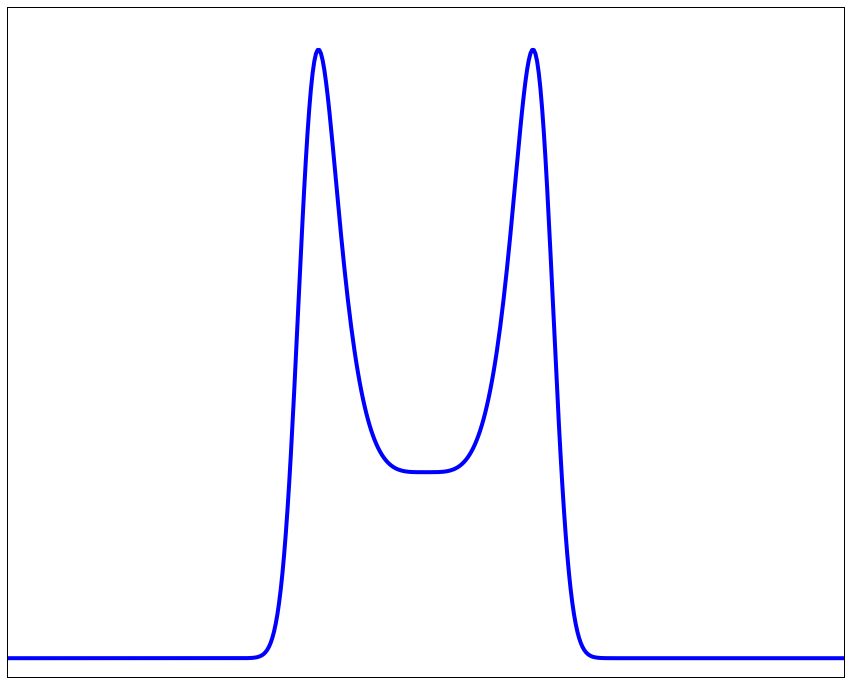

In [5]:
x = np.linspace(-10,10,1000)

xe = 0
xp = 0
b1 = 0.8
b2 = 0.8
a = 2
n = 4
w = 7
c = 0.002 
s = 5 

plt.plot(x, Double_horn(xe, xp, b1, b2, a, n, w, c, s, x), 'b-', linewidth = 4)
plt.ylim(-0.2, 7)
plt.xlim(-5, 5)

axs = plt.gca()
axs.tick_params(axis='both',which='both', bottom='off', top='off',left = 'off', right = 'off', labelbottom='off', labelleft='off')


fig = plt.gcf()
fig.set_size_inches(15.0,12.0)
fig.savefig('Double_horn.png')

In [6]:
name = 'mag.omcassan_0_22_526.det.lc.W149' 
tempdata = '/Users/Research/Desktop/alllc1/'+str(name)
#'data/WFIRST_simulated/Multi_caustic_crossing/'+str(name)

t,f,f_err,f_true,code = np.loadtxt(tempdata,usecols=(0,1,2,3,5),unpack=True)
df = pd.DataFrame({'t':t , 'A':f , 'A_err' : f_err , 'A_true': f_true, 'code':code})
df = df[df['code']==0]

IOError: /Users/Research/Desktop/alllc1/mag.omcassan_0_22_526.det.lc.W149 not found.

In [20]:
fname = gzip.open(tempdata, 'rb')
x_0 = fname.readlines()[0:7]
mag = x_0[1].split(' ')[3]
q_true = x_0[5].split(' ')[5]
s_true = x_0[5].split(' ')[6]

In [21]:
# print s_true, q_true

In [9]:
# Set up te directory where all microlensing data challenge lightcurves are

temp_dir = '/Users/Research/Library/Mobile Documents/com~apple~CloudDocs/Microlensing_Data_Challeng/data-challenge-1/alldclc/'
direc = os.listdir(temp_dir)

In [14]:
# Reading in one single lightcurve from the small sample of data challenge light curves

f = '/mag.omcassan_0_11_1456.det.lc.W149' #non-binary

t,m,e = np.loadtxt(temp_dir+f,unpack=True)

lightcurve = np.zeros((len(t),4))
lightcurve[:,0] = t
lightcurve[:,1] = m
lightcurve[:,2] = e
# peak = t[np.argmin(m)]
t = t-2458234


df, baseline, event, it0, dt = prepare(t,m,e)



In [15]:
# t_start = time.time()

# df, PSPL_final_params, PSPL_chisqr, A_residual, peaks, fp_double_horn, tp,\
# double_horn_chisqr, final_params, dev_counter, chisqr_final,\
# s_final, q_final, tEp= planetary_fitter (f)

# t_end = time.time()

# print t_end - t_start

In [16]:
init = initial_guess_finder (df['t'], df['A'])

print init[0], init[1], init[2]

1786.1733499998227 38.6487110001035 0.0986070427368962


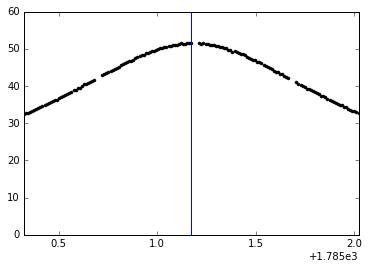

In [18]:
dtt = 0.022
plt.plot(df['t'],df['A'],'k.')
plt.xlim(init[0]-dtt*init[1],init[0]+dtt*init[1])
plt.axvline(init[0])

In [19]:
PSPL_final_params, PSPL_chisqr = PSPL_fitter_scipy (df['t'], df['A'], df['A_err'], init)

print PSPL_final_params

[1786.1886841439355, 43.89466596762418, 0.01581610313517294, 0.8109220493606065]


(1784.4328975052306, 1787.9444707826403)

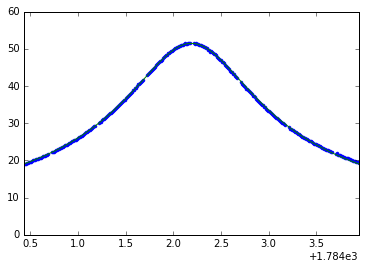

In [21]:
# PSPL_plotter (df['t'], df['A'], PSPL_final_params)
dtt = 0.04
plt.plot(df['t'], df['A'],'b.')
plt.plot(df['t'], PSPL(PSPL_final_params[0],PSPL_final_params[1],PSPL_final_params[2],PSPL_final_params[3], df['t']), 'g-')
plt.xlim(PSPL_final_params[0]-dtt*PSPL_final_params[1],PSPL_final_params[0]+dtt*PSPL_final_params[1])



In [22]:
df['A_residual'], peaks = PSPL_residual (df['t'], df['A'], PSPL_final_params)

In [23]:
n_peaks, peaks = deviation_finder (df['t'], df['A_residual'] , PSPL_final_params)

In [24]:
# n_out, peaks = count_peaks (df['t'], df['A_residual'] , smooth='yes', bin_size =2, threshold = 3)

(1784.8752720002085, 1788.8752720002085)

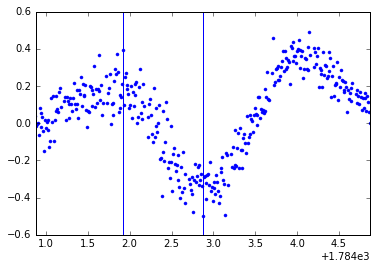

In [26]:
dtt =2
t_ = np.asarray(df['t'].values)
plt.plot(df['t'], df['A_residual'], 'b.')
#plt.plot(df['t']-2458234, Gaussian(temp[0][np.argmin(temp[1])]['tp'], temp[0][np.argmin(temp[1])]['tEp'],temp[0][np.argmin(temp[1])]['amp'], df['t']), 'r-')
# plt.plot(df['t']-2458234, Gaussian(t_[f_res.argmin()], 1.5,-0.2, df['t']), 'g-')
plt.axvline(peaks[0])
plt.axvline(peaks[1])
# 
plt.xlim(peaks[0]-dtt, peaks[0]+dtt)
# plt.xlim(init[0]-dtt*init[1],init[0]+dtt*init[1])



In [381]:
peaks

[146.95867499988526]

In [27]:
peaks[0]-peaks[1]

0.9545550001785159

In [28]:
fp_double_horn, tp, chisqr = double_horn_fitter_scipy (df['t'], df['A'], df['A_err'],df['A_residual'], peaks, PSPL_final_params)

In [29]:
tp

1786.3979945001192

In [385]:
# width = np.abs(peaks[1]-peaks[0])
# tp = min(peaks) + width/2.

In [386]:
# tp = min(peaks)

In [387]:
# a_init = np.median(df['A_residual'][(df['t']>min(peaks)) & (df['t']<max(peaks))])

# if a_init<0:
#     a_init = max(df['A_residual'])/100.
# else:
#     pass

In [388]:
# s_init = 5
# a_init = max(df['A_residual'])


In [389]:
# s_init

In [390]:
# params = Parameters()
# params.add('xe', value= 0, min=-5*s_init, max=5*s_init)
# params.add('xp', value= 0.01*s_init, min=-5*s_init, max=5*s_init)
# params.add('b1', value= 1,  min=0.1, max=20)
# params.add('b2', value= 1, min=0.1, max=20)
# params.add('c', value= 0.02, min=0, max=2)
# params.add('a', value= a_init, min=a_init/10., max=a_init*10.)
# params.add('n', value= 10,  min=6, max=15)
# params.add('w', value= (width/2.), min=(width/2.)/10., max=(width/2.)*10)
# params.add('s', value= s_init, min=1, max=50)


# result_res = minimize(Double_horn_data, params, args=(df['t'].values-tp, df['A_residual']))

In [391]:
# initials = [0.01*s_init, 0.01*s_init, 1, 1, a_init, 10, 1*s_init,0.02, s_init]
# nll = lambda *args: -lnlike_double_horn(*args)
# result = op.minimize(nll, initials, args=(df['t']-tp,df[ 'A_residual'], df['A_err']),method = 'Nelder-Mead')
# xe,xp, b1,b2, a, n, w, c, s = result['x']
# chisqr_double_horn = (-2*lnlike_double_horn([xe,xp, b1,b2, a, n, w, c, s],df['t']-tp,df[ 'A_residual'], df['A_err']))
# fp_double_horn = ([xe,xp, b1,b2, a, n, w, c, s])

In [392]:
# fp_double_horn

In [393]:
# initials = [0.01*5,  1, 1, min(df['A_residual']), 1*5, 5]
# nll = lambda *args: -lnlike_erfs(*args)
# result = op.minimize(nll, initials, args=(df['t']-tp,df[ 'A_residual'], df['A_err']),method = 'Nelder-Mead')
# xe, b1,b2, a, w, s = result['x']
# chisqr_double_horn = (-2*lnlike_erfs([xe, b1,b2, a, w, s],df['t']-tp,df[ 'A_residual'], df['A_err']))
# fp_double_horn = ([xe,0, b1,b2, a, 0, w, 0, s])

In [394]:
# c, n, xp = 0,0,0

In [395]:
# xe,xp, b1,b2, a, n, w, c, s = result_res.params['xe'],result_res.params['xp'], result_res.params['b1'],\
#                                 result_res.params['b2'], result_res.params['a'],\
#                                 result_res.params['n'],result_res.params['w'],result_res.params['c'], result_res.params['s']

In [30]:
xe,xp, b1,b2, a, n, w, c, s = fp_double_horn[0],fp_double_horn[1], fp_double_horn[2],\
                              fp_double_horn[3],fp_double_horn[4],\
                              fp_double_horn[5],fp_double_horn[6],fp_double_horn[7], fp_double_horn[8]

In [31]:
print xe,xp, b1,b2, a, n, w, c, s

-0.04269549029048336 0.1188451375692196 2.068801469776419 1.957283989000488 0.0008976308971903792 8.513677826579888 -2.612664095536418 0.016380040907999785 10.073971336442995


-0.04269549029048336 0.1188451375692196 2.068801469776419 1.957283989000488 0.0008976308971903792 8.513677826579888 -2.612664095536418 0.016380040907999785 10.073971336442995


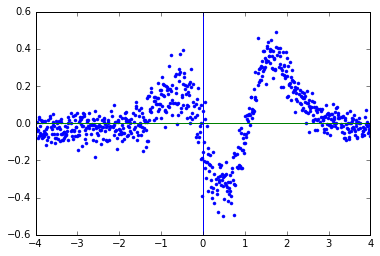

In [35]:
dtt =4
model = Double_horn(xe,xp, b1,b2, a, n, w, c, s, df['t']-tp)
# model = erfs(xe, b1,b2, a, w, s, df['t']-tp)


t_ = np.asarray(df['t'].values)
plt.plot(df['t']-tp, df['A_residual'], 'b.')
plt.plot(df['t']-tp, model,  'g-')
plt.xlim(-dtt,dtt)
plt.axvline(xe/s)
print xe,xp, b1,b2, a, n, w, c, s



In [284]:
# if tp> PSPL_final_params[0]:
#     xe_init = +1 * np.abs(tp-PSPL_final_params[0]) + (xe/s)
#     xp_init = +1 * np.abs(tp-PSPL_final_params[0]) + (xp/s)
# else: 
#     xe_init = -1 * np.abs(tp-PSPL_final_params[0]) + (xe/s)
#     xp_init = -1 * np.abs(tp-PSPL_final_params[0]) + (xp/s)

# print xe_init, xp_init

In [285]:
# s_init = 5

In [401]:
t_start = time.time()

final_params, dev_counter, chisqr_final = PSPL_double_horn_fitter_lmfit (df['t'], df['A'],df['A_err'], PSPL_final_params, fp_double_horn, tp)

t_end = time.time()

print t_end - t_start

30.8166930676


In [402]:
dev_counter

1

In [403]:


# params2 = Parameters()
# params2.add('t0', value= 0, min=-10, max=10)
# params2.add('tE', value= PSPL_final_params[1], min=PSPL_final_params[1]/2., max=PSPL_final_params[1]*2)
# params2.add('u0', value= PSPL_final_params[2], min=0, max=5)
# params2.add('fs', value= PSPL_final_params[3], min=PSPL_final_params[3]/1.1, max=PSPL_final_params[3]*1.1)
# params2.add('xe', value= xe_init*s, min=xe_init*s-10, max=xe_init*s+10)
# params2.add('xp', value= xp_init*s, min=xp_init*s-10, max=xp_init*s+10)
# params2.add('b1', value= b1,  min=b1/1.1, max=b1*1.1)
# params2.add('b2', value= b2 , min=b2/1.1, max=b2*1.1)
# params2.add('c', value= c  , min=c/1.01, max=c*1.01)
# params2.add('a', value= a, min=a/10., max=a*10.)
# params2.add('n', value= n,  min=n/1.1, max=n*1.1)
# params2.add('w', value= w, min=w/1.1, max=w*1.1)
# params2.add('s', value= s, min=s/1.5, max=s*1.5)


# result2 = minimize(Double_horn_PSPL_data, params2, args=(df['t'].values-PSPL_final_params[0], df['A']))

In [404]:
# result2.params

In [405]:
# t0, tE, u0, fs, xe, xp, b1, b2, a, n, w, c, s = result2.params['t0'], result2.params['tE'], result2.params['u0'],result2.params['fs'],\
#                                      result2.params['xe'],result2.params['xp'], result2.params['b1'],\
#                                      result2.params['b2'], result2.params['a'],\
#                                      result2.params['n'],result2.params['w'],result2.params['c'], result2.params['s']

In [406]:
t0, tE, u0, fs, xe, xp, b1, b2, a, n, w, c, s = final_params[0], final_params[1], final_params[2],final_params[3],\
                                     final_params[4],final_params[5], final_params[6],\
                                     final_params[7], final_params[8],\
                                     final_params[9],final_params[10],final_params[11], final_params[12]

In [407]:
print t0, tE, u0, fs, xe, xp, b1, b2, a, n, w, c, s

-0.032264716420442596 9.566521636129735 0.5853331496341913 0.20048091991811914 4727.68134291642 0 54.86434894212346 0.0217985005396537 0.2369120297409968 0 20.73372257332801 0 699.451537893594


In [408]:
t0 = PSPL_final_params[0]

In [409]:
-1*np.abs(tp-t0)+xe/s

-0.012448537822819183

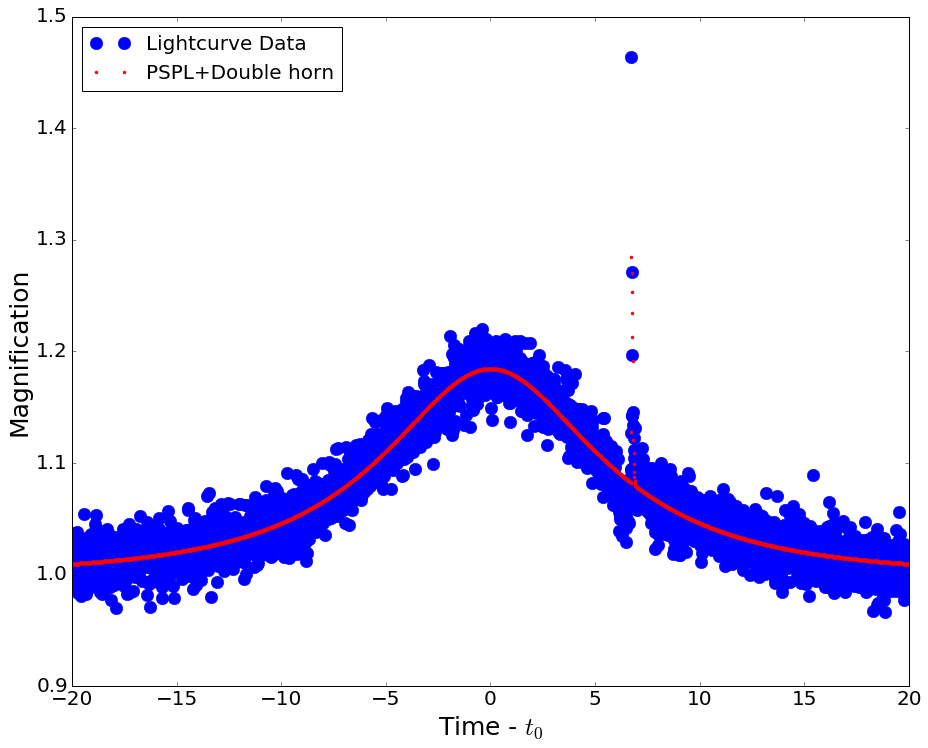

In [411]:
dtt = 20

plt.plot(df['t']-t0,df['A'],'b.', markersize=25, label='Lightcurve Data')
# plt.plot(df['t']-result1[0].value,Double_horn_PSPL(t0, tE, u0, fs, -1*xe, b1, 0.066, n, w, s, df['t']-result1[0].value),'r.', Label='Chebyshev Approximation')
plt.plot(df['t']-t0,
         Double_horn_PSPL(0, tE, u0, fs, xe, xp, b1, b2, a, n, w, c, s, df['t']-t0),'r.', Label='PSPL+Double horn')

# plt.axvline(xe/s)
# plt.axvline(max1 - final_params[0])
# plt.axvline(max2 - final_params[0])


plt.ylabel('Magnification', size=25)
plt.xlabel('Time - $t_0$', size=25)
#plt.title('Chebyshev approximation of a Binary-lens Microlensing Lightcurve',size=25)
plt.xlim(-dtt, +dtt)
plt.legend(loc=2,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# print cal_chisqr(PSPL(0,final_params[0],final_params[0],
#                       result1[3].value, df['t']-result1[0].value), df['A'], df['A_err'])
# # print cal_chisqr(Double_horn_PSPL(t0, tE, u0, fs,xe,b1, a, n, w, s, df['t']-result1[0].value),
# #                 df['A'], df['A_err'])
# print cal_chisqr(PSPL(0, result1[1].value, result1[2].value, result1[3].value, df['t']-result1[0].value)+\
#                  Double_horn(xe, xp, b1, b2, a, n, w, c, s, df['t']-result1[0].value),
#                  df['A'], df['A_err'])
fig = plt.gcf()
fig.set_size_inches(15.0,12.0)
# plt.savefig('Chebyshevfit_success.png')

(-31, -29)

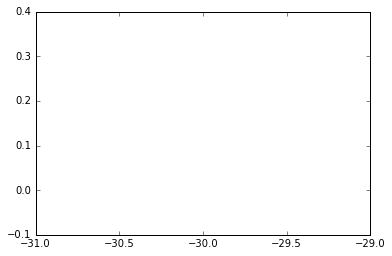

In [412]:

dtt =1

plt.plot(df['t']-t0, (df['A_residual']), 'b.')


plt.plot(df['t']-t0, 1*model, 'g-')
plt.axvline(tp-t0)
# plt.axvline(xe/s - w/s)
# plt.axvline(xe/s + w/s)
# plt.axvline(max1-t0)
# plt.axvline(max2-t0)

# plt.axhline(np.median(model[model != 0.0]), color = 'r')
plt.xlim(-30-dtt, -30+dtt)

# print max2-max1

In [236]:
df['t'][pd.idxmax(df.A)]

AttributeError: 'module' object has no attribute 'idxmax'

In [54]:
if c==0:
    df_new = df [ (df.t > tp-10) & (df.t < tp+10)]
    model_new = Double_horn(xe,xp, b1,b2, a, n, w, c, s, df_new['t']-tp)
    double_check =  np.abs(np.sum((df_new['A_residual']-model_new)[(df_new['A_residual']-model_new)<0])/np.sum((df_new['A_residual']-model_new)[(df_new['A_residual']-model_new)>0]))
    
else:
    tp_dd = max1+(max2-max1)/2
    tEp = (max(df['t'][model > min_model]) - min(df['t'][model > min_model]))/2
    df_new = df[ (df.t > tp_dd-tEp-5) & (df.t < tp_dd+tEp+5)]
    model_new = Double_horn(xe,xp, b1,b2, a, n, w, c, s, df_new['t']-tp_dd)
    double_check =  np.abs(np.sum((df_new['A_residual']-model_new)[(df_new['A_residual']-model_new)<0])/np.sum((df_new['A_residual']-model_new)[(df_new['A_residual']-model_new)>0]))
    
print double_check

NameError: name 'max1' is not defined

In [237]:
# np.abs(np.sum((df['A_residual']-model)[(df['A_residual']-model)<0]))/np.abs(np.sum((df['A_residual']-model)[(df['A_residual']-model)>0]))

In [238]:
# (model[model!= 0.0])

In [416]:
model = Double_horn(xe,xp, b1,b2, a, n, w, c, s, df['t']-tp)

# df['A_residual'] = A_residual

if np.mean(model[model!= 0.0])>0:
    
    min_model = 0.0001
else:
    min_model = -0.0001
    
cc = 'None'
if (c != 0) & (min_model > 0):
    max1 = df['t'][np.argmax(model[df['t']>(np.median(df['t'][model>min_model]))])]
    max2 = df['t'][np.argmax(model[df['t']<(np.median(df['t'][model>min_model]))])]
    tEp = (max(df['t'][model > min_model]) - min(df['t'][model > min_model]))/2
    cc = 'Major'
    
    tp_dd = max1+(max2-max1)/2
    df_new = df[ (df.t > tp_dd-tEp-5) & (df.t < tp_dd+tEp+5)]
    model_new = Double_horn(xe,xp, b1,b2, a, n, w, c, s, df_new['t']-tp_dd)
    double_check =  np.abs(np.sum((df_new['A_residual']-model_new)[(df_new['A_residual']-model_new)<0])/np.sum((df_new['A_residual']-model_new)[(df_new['A_residual']-model_new)>0]))
    #double_check = np.abs(np.sum((df['A_residual']-model)[(df['A_residual']-model)<0]))/np.abs(np.sum((df['A_residual']-model)[(df['A_residual']-model)>0]))
#     new_f = df[(df.t>min([max1,max2])) & (df.t>max([max1,max2]))]
#     new_model = Double_horn( xe, xp, b1, b2, a, n, w, c, s, new_f['t']-t0)
#     double_check = np.median((df['A_residual']-model))
    print double_check

if (c != 0) & (min_model < 0):
    max1 = df['t'][np.argmin(model[df['t']>(np.median(df['t'][model<min_model]))])]
    max2 = df['t'][np.argmin(model[df['t']<(np.median(df['t'][model<min_model]))])]
    tEp = (max(df['t'][model < min_model]) - min(df['t'][model < min_model]))/2
    cc = 'Minor'


#print cc

t1 = max1
t2 = max2



u1 = np.sqrt( ((t1-t0)/tE)**2 + (u0)**2 )
u2 = np.sqrt( ((t2-t0)/tE)**2 + (u0)**2 )

s0s1 = np.sqrt( (u1)**2 - (u0)**2 )
s0s2 = np.sqrt( (u2)**2 - (u0)**2 )
s1s2 = s0s1 - s0s2



    
if cc == 'Major':
#     print 'major'
    
    xs1 = (s1s2 * s0s1) / u1
    Lx = u1 - xs1
    
    s0 = Symbol('s0')
    s_final = (solve(s0-(1/s0)-Lx, s0))[1]
    if (xs1 > u1):
        q_final = ((max2 - max1)/tE)**2
    else:
        q_final = ( xs1*float(s_final)*np.sqrt(float(s_final**2 -1))/2. )**2
    q_final2 = (tEp/tE)**2
    q_final = (q_final2+q_final)/2
    
    if double_check > 1:
        cc = 'Minor'

        
if cc == 'Minor':
    xs1 = s1s2/2.
    xs0 = s0s2 + xs1
    Lx = np.sqrt( (xs0 ** 2) + (u0 **2))
    
    s0 = Symbol('s0')
    s_final = (solve((1/s0)-s0-Lx, s0))[1]
    
    q_final = (16 * (s1s2**2))/((256./s_final**2)+27*s_final**6)
    
#     q_final2 = (tEp/tE)**2
#     q_final = (q_final2+q_final)/2


if np.abs(max1-max2)<0.2:
    c = 0

    
if c == 0:
    if min_model > 0 :
        tp_ = df['t'][np.argmax(model)]-t0
        cc = 'Major'
        df_new = df [ (df.t > tp-10) & (df.t < tp+10)]
        tEp = (max(df['t'][model > min_model]) - min(df['t'][model > min_model]))/2
        model_new = Double_horn(xe,xp, b1,b2, a, n, w, c, s, df_new['t']-tp)
        double_check =  np.abs(np.sum((df_new['A_residual']-model_new)[(df_new['A_residual']-model_new)<0])/np.sum((df_new['A_residual']-model_new)[(df_new['A_residual']-model_new)>0]))
        print double_check
        if double_check > 1:
            tp_ = df['t'][np.argmin(model)]-t0
            cc = 'Minor'

    else:
        tEp = (max(df['t'][model < min_model]) - min(df['t'][model < min_model]))/2
        tp_ = df['t'][np.argmin(model)]-t0
        cc = 'Minor'
    
#     print tp
    u = np.sqrt( ((tp_)/tE)**2 + (u0)**2 )
#     print tE
    s0 = Symbol('s0')
    s_final = (solve(s0-(1/s0)-u, s0))[1]
#     print s_final

    if cc == 'Minor':
        s_final = 1./s_final

    q_final = (tEp/tE)**2


1.1079759380244019


In [415]:
s_final, q_final, tEp = calculate_s_q (df['t']-PSPL_final_params[0], df['A_residual'],peaks, final_params)

NameError: global name 'df' is not defined

In [414]:
print s_final, q_final

0.306838603961900 0.00010926990577211074


In [33]:
print s_true, q_true

1.19573 0.0206924


In [68]:
(tEp/tE)**2

0.00037722655090719517

In [12]:
x = Symbol('x')
print (solve(x + sympy.sqrt((x**2)+4)-2, x))

[0]


In [87]:
tp_

-1498.0751595979